In [1]:
# env: zanalytics

import numpy as np
import pandas as pd

In [2]:
np.random.seed(42)

In [3]:
# ------------------------------------------------
# Parameters
# ------------------------------------------------
N_USERS = 10_000

TENANTS = [f"tenant_{i}" for i in range(1, 6)]
INDUSTRIES = ["Retail", "Finance", "Gaming"]
PHONE_TYPES = ["iOS", "Android", "Web"]
PRODUCT_CATEGORIES = [f"category_{i}" for i in range(1, 11)]

In [4]:
# ------------------------------------------------
# Base user assignments
# ------------------------------------------------
df = pd.DataFrame({
    "user_id": np.arange(1, N_USERS + 1),
    "tenant": np.random.choice(TENANTS, N_USERS),
    "industry": np.random.choice(INDUSTRIES, N_USERS),
    "time_with_us_days": np.random.randint(1, 2000, N_USERS),  # 1-2000 days
    "is_active": np.random.choice([0, 1], N_USERS, p=[0.3, 0.7]),  # 70% active
    "is_blocked": np.random.choice([0, 1], N_USERS, p=[0.95, 0.05]),  # 5% blocked
    "phone_type": np.random.choice(PHONE_TYPES, N_USERS, p=[0.35, 0.55, 0.10]),  # more Android
})

In [6]:
# ------------------------------------------------
# Conversions depend on activity
# ------------------------------------------------
conversion_prob = (
    0.25 * df["is_active"] +  # active users convert more
    0.05 * (~df["is_active"].astype(bool)) -  # inactive users convert sometimes
    0.20 * df["is_blocked"]  # blocked users convert less
)

conversion_prob = np.clip(conversion_prob, 0.01, 0.8)
df["has_conversions"] = np.random.binomial(1, conversion_prob)

In [7]:
# ------------------------------------------------
# Product categories purchased
# Option: each user can have 1–5 purchased categories randomly
# ------------------------------------------------
num_categories = np.random.randint(1, 6, N_USERS)

user_categories = []
for n in num_categories:
    cats = np.random.choice(PRODUCT_CATEGORIES, n, replace=False)
    user_categories.append(",".join(cats))

df["product_categories"] = user_categories

In [9]:
# ------------------------------------------------
# Final dataset
# ------------------------------------------------
display(df.head())
print(df.shape)

# Optional: save to CSV
# df.to_csv("simulated_user_data.csv", index=False)


,user_id,tenant,industry,time_with_us_days,is_active,is_blocked,phone_type,has_conversions,product_categories
0,1,tenant_4,Finance,421,1,0,Android,0,"category_9,category_6,category_4,category_1,ca..."
1,2,tenant_5,Finance,7,0,0,Android,0,"category_10,category_9,category_4,category_1,c..."
2,3,tenant_3,Gaming,1882,1,0,Android,0,category_3
3,4,tenant_5,Retail,1549,0,0,Android,0,"category_6,category_9"
4,5,tenant_5,Gaming,592,1,0,Android,1,"category_3,category_6,category_4"


(10000, 9)


## Part 2

In [26]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA


In [10]:
# Create a numeric feature for number of categories bought
df["num_categories"] = df["product_categories"].apply(lambda x: len(x.split(",")))

# Select features
features = df[[
    "time_with_us_days", 
    "is_active", 
    "is_blocked", 
    "has_conversions",
    "num_categories",
    "tenant", 
    "industry", 
    "phone_type"
]]

In [12]:
numeric_features = ["time_with_us_days", "is_active", "is_blocked", "has_conversions", "num_categories"]
categorical_features = ["tenant", "industry", "phone_type"]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first"), categorical_features)
])

In [14]:
X = preprocess.fit_transform(features)

In [15]:
inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

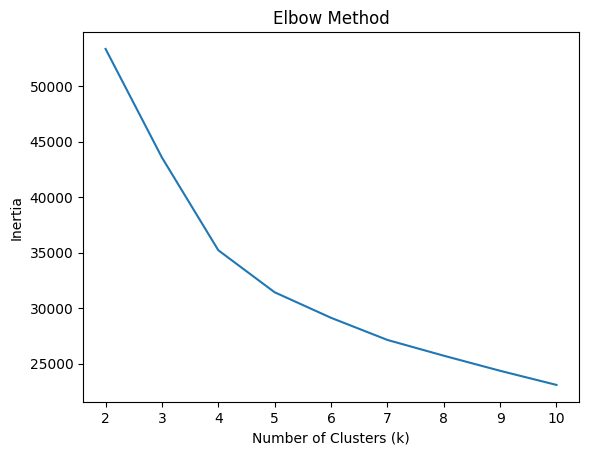

In [16]:
plt.plot(K_range, inertias)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [17]:
k = 5

kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
clusters = kmeans.fit_predict(X)

df["segment"] = clusters

In [19]:
segment_profile = df.groupby("segment").agg({
    "time_with_us_days": "mean",
    "is_active": "mean",
    "is_blocked": "mean",
    "has_conversions": "mean",
    "num_categories": "mean",
    "tenant": lambda x: x.mode()[0],
    "industry": lambda x: x.mode()[0],
    "phone_type": lambda x: x.mode()[0],
    "user_id": "count"
}).rename(columns={"user_id": "num_users"})

display(segment_profile)

,time_with_us_days,is_active,is_blocked,has_conversions,num_categories,tenant,industry,phone_type,num_users
segment,,,,,,,,,
0,1123.199363,1.000000,0.0,0.000000,4.187027,tenant_5,Gaming,Android,2513
1,991.716804,0.000000,0.0,0.000000,3.032633,tenant_2,Finance,Android,2666
2,918.427416,1.000000,0.0,0.000000,1.772746,tenant_1,Finance,Android,2473
3,1021.301775,0.668639,1.0,0.047337,2.974359,tenant_1,Finance,Android,507
4,1004.925584,0.933732,0.0,1.000000,2.983161,tenant_2,Gaming,Android,1841


In [21]:
gmm = GaussianMixture(n_components=5, random_state=42)
df["segment_gmm"] = gmm.fit_predict(X)

In [23]:
db = DBSCAN(eps=1.2, min_samples=50)
df["segment_dbscan"] = db.fit_predict(X)

In [25]:
hc = AgglomerativeClustering(n_clusters=5)
df["segment_hierarchical"] = hc.fit_predict(X)

In [ ]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X)

df["pca_x"] = pca_coords[:, 0]
df["pca_y"] = pca_coords[:, 1]

In [29]:
df['segment'].value_counts()

segment
1    2666
0    2513
2    2473
4    1841
3     507
Name: count, dtype: int64

In [40]:
df.head()

,user_id,tenant,industry,time_with_us_days,is_active,is_blocked,phone_type,has_conversions,product_categories,num_categories,segment,segment_gmm,segment_dbscan,segment_hierarchical,pca_x,pca_y
0,1,tenant_4,Finance,421,1,0,Android,0,"category_9,category_6,category_4,category_1,ca...",5,0,0,0,4,0.070595,-1.006505
1,2,tenant_5,Finance,7,0,0,Android,0,"category_10,category_9,category_4,category_1,c...",5,1,2,1,1,-1.413132,-2.016974
2,3,tenant_3,Gaming,1882,1,0,Android,0,category_3,1,2,0,0,0,0.262207,1.442617
3,4,tenant_5,Retail,1549,0,0,Android,0,"category_6,category_9",2,1,2,1,1,-1.238252,0.476800
4,5,tenant_5,Gaming,592,1,0,Android,1,"category_3,category_6,category_4",3,4,3,2,3,1.929061,-0.679609


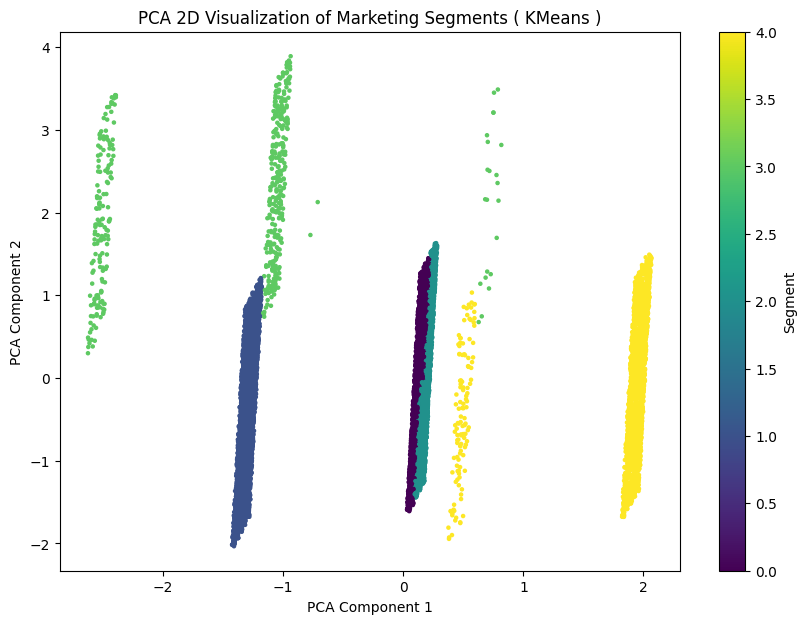

In [41]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    df["pca_x"], df["pca_y"],
    c=df["segment"], s=5
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA 2D Visualization of Marketing Segments ( KMeans )")
plt.colorbar(scatter, label="Segment")
plt.show()

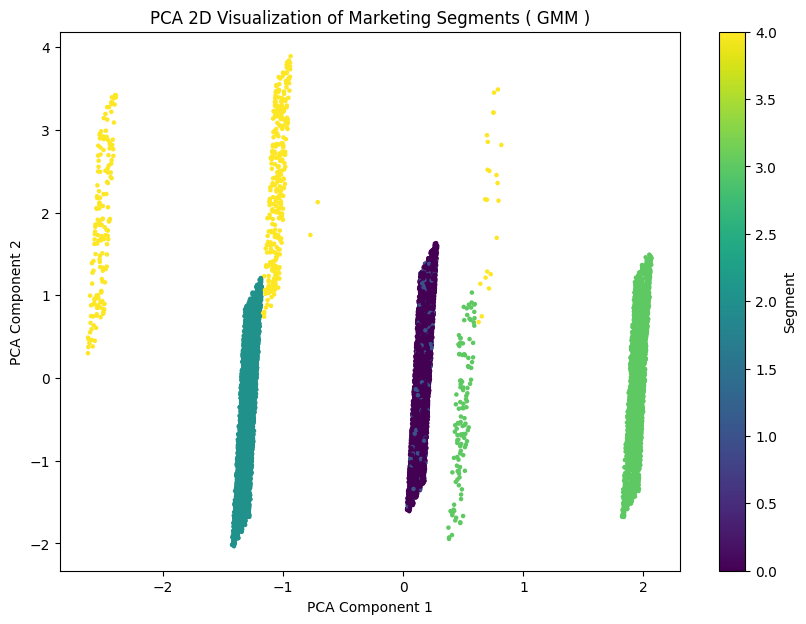

In [42]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    df["pca_x"], df["pca_y"],
    c=df["segment_gmm"], s=5
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA 2D Visualization of Marketing Segments ( GMM )")
plt.colorbar(scatter, label="Segment")
plt.show()

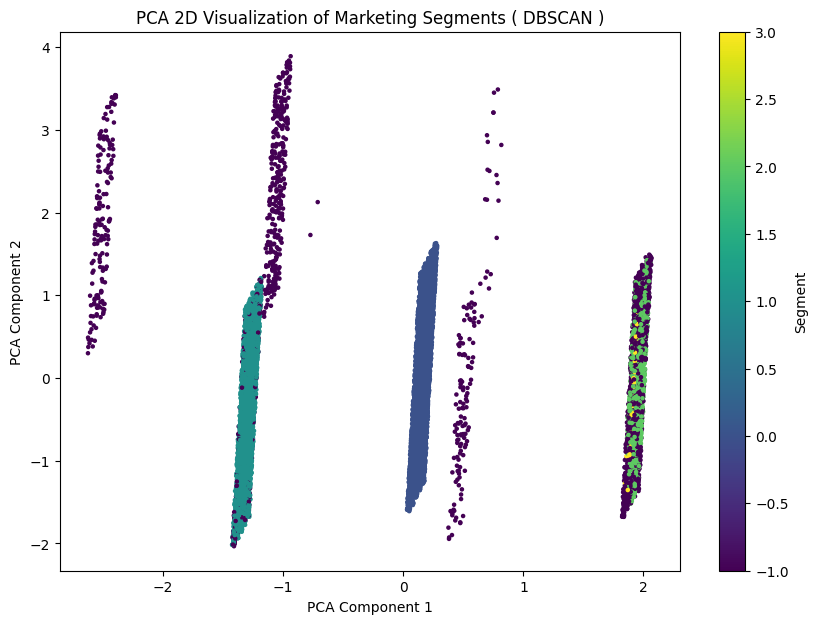

In [43]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    df["pca_x"], df["pca_y"],
    c=df["segment_dbscan"], s=5
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA 2D Visualization of Marketing Segments ( DBSCAN )")
plt.colorbar(scatter, label="Segment")
plt.show()

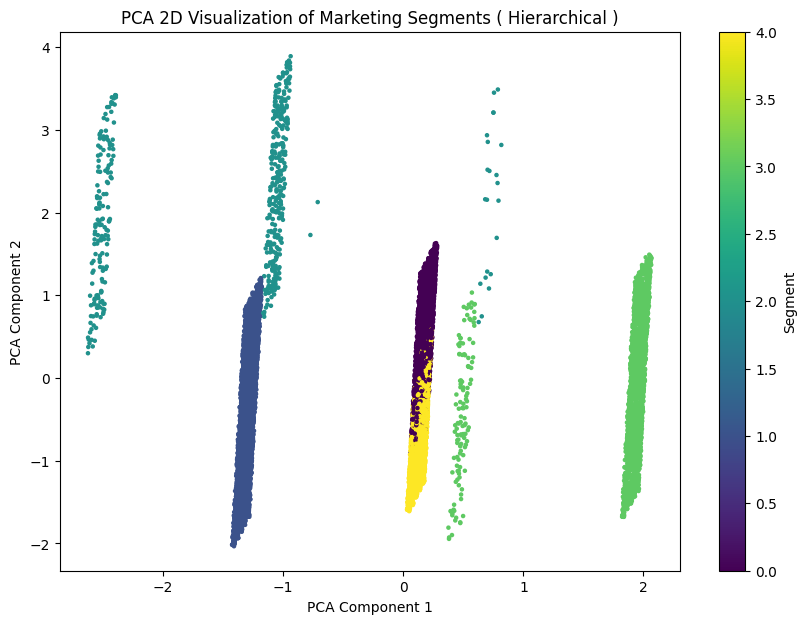

In [44]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    df["pca_x"], df["pca_y"],
    c=df["segment_hierarchical"], s=5
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA 2D Visualization of Marketing Segments ( Hierarchical )")
plt.colorbar(scatter, label="Segment")
plt.show()

In [36]:
# ----------------------------------------------------
# 6. Behavioral Profile Table
# ----------------------------------------------------

segment_profile = df.groupby("segment").agg({
    "user_id": "count",
    "time_with_us_days": "mean",
    "is_active": "mean",
    "is_blocked": "mean",
    "has_conversions": "mean",
    "num_categories": "mean",
    "tenant": lambda x: x.mode()[0],
    "industry": lambda x: x.mode()[0],
    "phone_type": lambda x: x.mode()[0],
}).rename(columns={"user_id": "num_users"})

print("\n=== Behavioral Segment Profile ===\n")
display(segment_profile)



=== Behavioral Segment Profile ===



,num_users,time_with_us_days,is_active,is_blocked,has_conversions,num_categories,tenant,industry,phone_type
segment,,,,,,,,,
0,2513,1123.199363,1.000000,0.0,0.000000,4.187027,tenant_5,Gaming,Android
1,2666,991.716804,0.000000,0.0,0.000000,3.032633,tenant_2,Finance,Android
2,2473,918.427416,1.000000,0.0,0.000000,1.772746,tenant_1,Finance,Android
3,507,1021.301775,0.668639,1.0,0.047337,2.974359,tenant_1,Finance,Android
4,1841,1004.925584,0.933732,0.0,1.000000,2.983161,tenant_2,Gaming,Android


In [38]:
# ----------------------------------------------------
# 7. Distribution Heatmap
# ----------------------------------------------------

heatmap_data = df.groupby("segment")[[
    "time_with_us_days",
    "is_active",
    "is_blocked",
    "has_conversions",
    "num_categories"
]].mean()

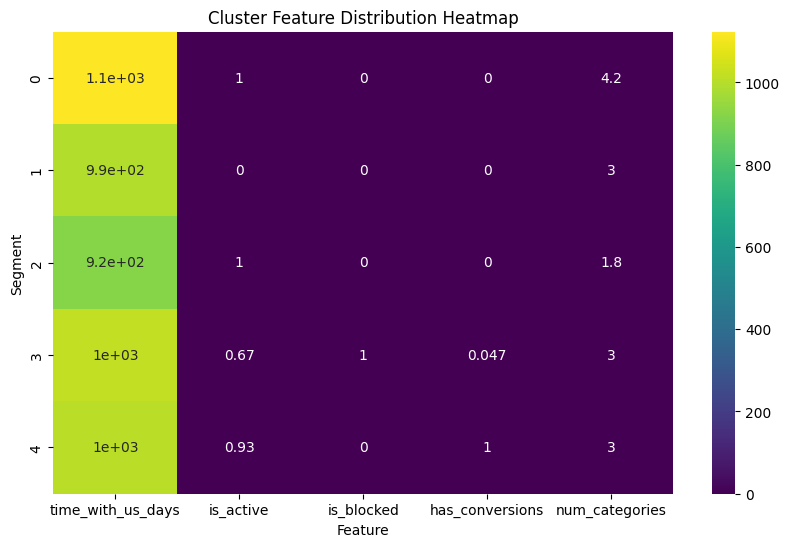

In [ ]:
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis")
plt.title("Cluster Feature Distribution Heatmap")
plt.ylabel("Segment")
plt.xlabel("Feature")
plt.show()